In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sys

In [2]:
#initialize constant values
b = 0.5
k = 1
m = 1

In [3]:
#set time step and calculate vector of timestamps
Tp = 0.1
Tf = 10
samples = int(Tf/Tp + 1)

T = np.linspace(0,Tf,samples)
T

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

In [4]:
#prepare all input signals - control U and noised W and V
U = np.full(samples, 1)
W = np.random.normal(0,1,samples)


In [5]:
V = np.random.normal(0,1,samples) #for now assume no process noise V (model is perfect)

In [6]:
U2 = U + V


In [7]:
U2

array([ 2.61879652e+00,  1.54587492e+00,  2.35282328e+00,  1.58884358e+00,
        1.40629460e+00,  2.71050414e-01,  1.99220492e+00,  1.47314208e+00,
       -5.61240487e-01,  2.00420154e+00,  1.90075929e+00,  6.30074564e-01,
        6.86091827e-01,  2.45271205e+00,  7.90460098e-01,  1.83599569e+00,
        1.05207506e+00,  2.40898571e-01, -3.35095671e-01,  1.72791310e+00,
       -1.27103202e+00,  1.08700088e+00,  2.87221762e+00,  6.40616977e-01,
       -8.14148545e-01,  9.74642484e-01,  1.49464541e+00,  1.27296749e+00,
        2.13151582e+00,  1.58701402e+00,  2.87093119e+00,  2.72107874e+00,
        7.76977204e-01,  9.09529739e-02,  4.84498583e-01,  4.90934483e-01,
        1.39802266e+00, -6.26529115e-03,  1.37392481e+00, -1.35430811e+00,
       -6.76506280e-01,  1.65619389e+00,  1.50727781e+00,  2.98285064e+00,
       -2.98457414e-02,  7.17209651e-01,  4.11924745e-01,  7.97067384e-01,
        1.29558470e+00,  4.65460433e-01, -3.97032098e-02,  2.57949271e+00,
        2.35100316e-03,  

In [8]:
#define arrays A, B and C and D of a linear system
A = np.array([[0, 1],
              [-k/m, -b/m]])

B = np.array([[0],
              [1/m]])

C = np.array([[1, 0]])

D = np.array([[0]])

In [9]:
#simulate the dynamic system, pass matrices of linear system model, control signal and timestamps
res = signal.lsim([A,B,C,D],U2,T)
X = res[2].T
Y = res[1]

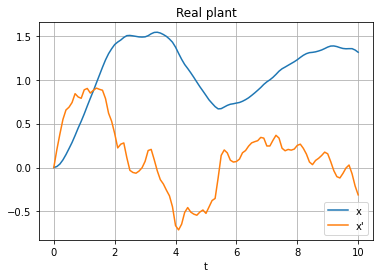

In [10]:
#plot states of dynamic system
plt.figure()
plt.plot(T, X[0], label='x')
plt.plot(T, X[1], label="x'")
plt.title("Real plant")
plt.legend(loc=4)
plt.xlabel("t")

plt.grid()
plt.savefig("real plant.pdf")

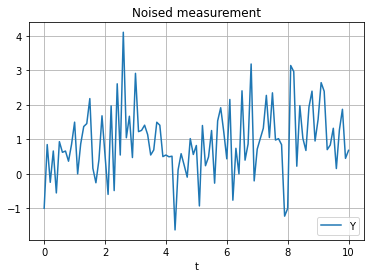

In [12]:
#add noise to the measurement
Y = Y + W

plt.figure()
plt.plot(T,Y, label="Y")
plt.xlabel("t")
plt.title("Noised measurement")
plt.grid()
plt.legend(loc=4)
plt.savefig("real plant noise.pdf")

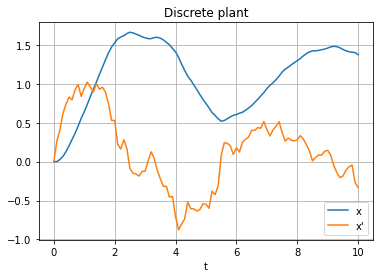

In [13]:
#calculate matrices A, B, C and D of discrete-time system based on continous system
discr = signal.cont2discrete((A, B, C, D), Tp, 'euler')

A1 = discr[0]
B1 = discr[1]
C1 = discr[2]
D1 = discr[3]

res2 = signal.dlsim((A1,B1,C1,D1,T), U2)

X1 = res2[2].T
Y1 = res2[1]

plt.figure()
plt.plot(T, X1[0], label='x')
plt.plot(T, X1[1], label="x'")
plt.title("Discrete plant")
plt.xlabel("t")
plt.legend(loc=4)
plt.grid()
plt.savefig("disc plant.pdf")

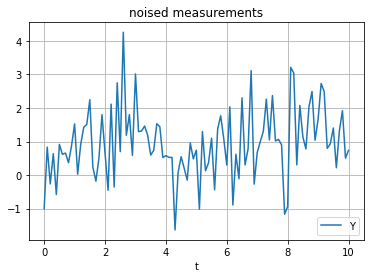

In [14]:
for i in range(len(T)):
    Y1[i] = Y1[i] + W[i]

plt.plot(T, Y1, label='Y')
plt.xlabel("t")
plt.title("noised measurements")
plt.legend(loc=4)
plt.grid()
plt.savefig("dsic plant noise.pdf")

In [43]:
#initialize all matrices of Kalman Filter - feel free to change these values  
Xp = np.array([[1],[1]])
Pp = np.array([[2,5],[5,2]])

Q = 0.1 #Q - assumed covariance of process noise
R = 100  #R - assumed covariance of measurement noise
R

100

In [44]:
#some vectors to keep samples of Xc apriori and Xp aposteriori estimate for later plotting
XC = Xp.T
XP = Xp.T

#main loop of discrete-time simulation
for i in range(0,samples - 1):  
    # Kalman filter
    
    Xc = A1 @ Xp + B1 @ np.matrix(U2[i])
    Pc = A1 @ Pp @ A1.T + Q
    
    S = C1 @ Pc @ C1.T + R
    K = Pc @ C1.T @ np.linalg.inv(S)
    e = np.matrix(Y1[i]) - C1 @ Xc
    Xp = Xc + K @ e
    Pp = Pc - K @ S @ K.T
    
    # Add calculated values to XC and XP 
    XC = np.vstack([XC, Xc.T])
    XP = np.vstack([XP, Xp.T])

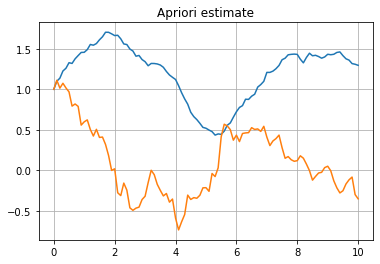

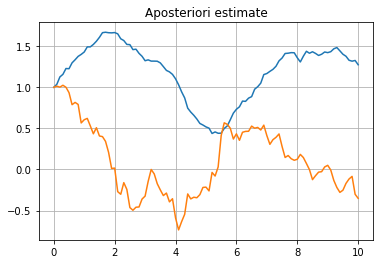

In [45]:
#plot the results
plt.figure()
plt.plot(T, XC)
plt.title("Apriori estimate")
plt.grid()
plt.savefig("apriori9.pdf")

plt.figure()
plt.plot(T, XP)
plt.title("Aposteriori estimate")
plt.grid()
plt.savefig("aposteriori9.pdf")